# RL and Advanced DL: Домашнее задание 1
Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.


In [137]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import gym

from tqdm import tqdm

# 1. Часть первая, с блекджеком и стратегиями

**1.1** `Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.`

In [603]:
# количество состояний
# 0 - 3 бесполезные, но для удобства их оставлю
# 22 - для любой суммы, когда мы больше 21 взяли (бесполезно для MC, но для TD пригодится)
nS = 23

# количество действий
nA = 2

In [3]:
# простая стратегия
pi_simple = np.ones(nS, dtype=int)
pi_simple[[19, 20, 21, 22]] = 0
pi_simple

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0])

In [4]:
def run_episode(env, pi, eps=0.0):
    """Играем один эпизод."""
     
    state = env.reset()[0]
    terminated = False
    
    states, actions, rewards = [], [], []
    
    while not terminated:
        
        sum_hand = state[0]
        
        if np.random.rand() > eps:
            action = pi[sum_hand]
        else:
            action = np.random.randint(nA)
        
        state, reward, terminated, _, _ = env.step(action)
        
        states.append(sum_hand)
        actions.append(action)
        rewards.append(reward)
        
    return states, actions, rewards

In [604]:
def get_mean_reward(env, pi, n_episodes):
    """Расчет среднего выигрыша."""
    
    mean_reward = 0  # средний выигрыш
    
    for i in range(n_episodes):
        _, _, rewards = run_episode(env, pi)
        mean_reward = (mean_reward * i + rewards[-1]) / (i + 1)
        
    return mean_reward

Случай, когда играем с **natural blackjack**

In [6]:
env = gym.make("Blackjack-v1", natural=True, sab=False)

mean_reward = get_mean_reward(env=env, pi=pi_simple, n_episodes=1_000_000)

print(f"Mean reward with natural=True: {np.round(mean_reward, 3)}")

Mean reward with natural=True: -0.18


Случай, когда играем по правилам из книги **Reinforcement Learning: An Introduction by Sutton and Barto**

In [7]:
env = gym.make("Blackjack-v1", natural=False, sab=True)

mean_reward = get_mean_reward(env=env, pi=pi_simple, n_episodes=1_000_000)

print(f"Mean reward with sab=True: {np.round(mean_reward, 3)}")

Mean reward with sab=True: -0.196


**Вывод:** 
* Проигрываем в среднем $0.18$ для случая `natural=True` и $0.2$ для `sab=True`. 
* Далее будем работать с **natural blackjack**.

**1.2** `Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.`

**1.3** `Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.`

In [8]:
env = gym.make("Blackjack-v1", natural=True, sab=False)

# On-policy Monte Carlo control

In [605]:
def compute_policy_by_Q(Q):
    """Политика."""
    return np.argmax(Q, axis=1)


def update_Q(states, actions, rewards, n_episode, gamma=1.0):
    """Обновляем матрицу Q."""
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t
            
    g = 0
    for t in range(len(states) - 1, -1, -1):
        g =  g * gamma + rewards[t]
        if state_first_visit[states[t]] == t:
            Q[states[t]][actions[t]] = (Q[states[t]][actions[t]] * n_episode + g) / (n_episode + 1)
            
            
def mean_reward_plot(x, y, title=""):
    """График среднего дохода."""
    plt.figure(figsize=(10, 4))
    plt.plot(x, y)
    plt.plot(x, y, "o")
    plt.title(title)
    plt.ylabel("mean reward")
    plt.xlabel("episode number")
    plt.grid()

In [11]:
# Разыгрываем total_episodes раздач до конца. 
# По итогам каждого разыгранного эпизода обновляем матрицу Q и стратегию pi.
# Каждые check_pi_step шагов проверяем стратегию, расчитывая средний выигрыш.

# action-value function
Q = np.zeros((nS, nA))

total_episodes = 100_001
check_pi_step = 5000  # как часто проверяем стратегию
gamma = 0.9
eps = 0.1

mean_reward_by_current_policy = []

for n_episode in tqdm(range(total_episodes)):
    # текущая стратегия
    pi = compute_policy_by_Q(Q)
    
    if n_episode % check_pi_step == 0:
        mean_reward = get_mean_reward(env, pi, n_episodes=500_000)
        mean_reward_by_current_policy.append(mean_reward)
    
    # проигрываем эпизод
    states, actions, rewards = run_episode(env, pi, eps=eps)  
    # обновляем Q
    update_Q(states, actions, rewards, n_episode, gamma=gamma)

100%|███████████████████████████████████| 100001/100001 [26:02<00:00, 64.01it/s]


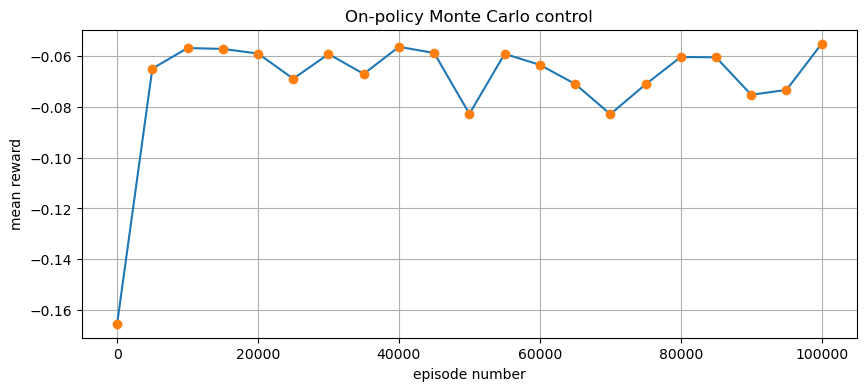

In [12]:
mean_reward_plot(
    x=np.arange(0, total_episodes, check_pi_step),
    y=mean_reward_by_current_policy, 
    title="On-policy Monte Carlo control"
)

**Полученная матрица Q**

In [13]:
print(Q)

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.02252232 -0.02252143]
 [-0.0225634  -0.022524  ]
 [-0.05494464 -0.05494224]
 [-0.99704662 -0.12255508]
 [-0.02417524 -0.02417134]
 [-0.03552599 -0.03050064]
 [-0.06456035  0.00610805]
 [-0.12428564  0.01540458]
 [-0.20836598 -0.20829774]
 [-0.49421628 -0.25207274]
 [-0.32591237 -0.32155519]
 [-0.23977971 -0.23973849]
 [-0.1867185  -0.18672055]
 [-0.20052138 -0.2005441 ]
 [-0.05672665 -0.15577346]
 [ 0.07609147 -0.16242571]
 [ 0.31279803 -0.2472327 ]
 [ 0.6954419  -0.02148995]
 [ 0.          0.        ]]


**Выводы:**

* Средний проигрыш уменьшился примерно в 2 раза: с $0.18$ до $0.06\ ..\ 0.08$ в среднем. *Лучший результат: проигрыш $0.06$.*
* Из анализа матрицы **Q** следует, что когда на руках $19$, $20$ и $21$, то выгоднее остановиться, чем добирать. Тогда, вероятнее, выиграть.
* Интересный результат получился, когда на руках $11$ - положительный средний выигрыш, если добирать дальше карты.
* А так часто ситуация, когда одинаково плохо и добирать и останавливаться.

# Off-policy Monte Carlo control

In [14]:
def update_lists(s, a, g, w, Q, C):
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]


def update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=0.1, gamma=1.0):
    
    g, w, prob_best_action = 0., 1., 1 - (nA - 1) * epsilon / nA

    # Обновляем функции для последнего хода
    update_lists(states[-1], actions[-1], g, w, Q, C)
    
    for t in range(len(states) - 1, -1, -1):
        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if actions[t] != pi[states[t]]:
            break
            
        # Обновляем веса и return
        w = w / prob_best_action
        g =  g * gamma + rewards[t]
        
        # Обновляем функции
        update_lists(states[t], actions[t], g, w, Q, C)
        
    return Q, C

In [15]:
# action-value function
Q = np.zeros((nS, nA))

C = np.zeros((nS, nA), dtype=float)

total_episodes = 100_001
check_pi_step = 5000  # как часто проверяем стратегию
gamma = 0.9
eps = 0.1

mean_reward_by_current_policy = []

for n_episode in tqdm(range(total_episodes)):
    # текущая стратегия
    pi = compute_policy_by_Q(Q)
    
    if n_episode % check_pi_step == 0:
        mean_reward = get_mean_reward(env, pi, n_episodes=500_000)
        mean_reward_by_current_policy.append(mean_reward)
    
    # проигрываем эпизод
    states, actions, rewards = run_episode(env, pi, eps=eps)  
    # обновляем Q
    Q, C = update_returns_actions_offpolicy_MC(
        Q, C, pi, states, actions, rewards, gamma=gamma
    )

100%|███████████████████████████████████| 100001/100001 [24:59<00:00, 66.69it/s]


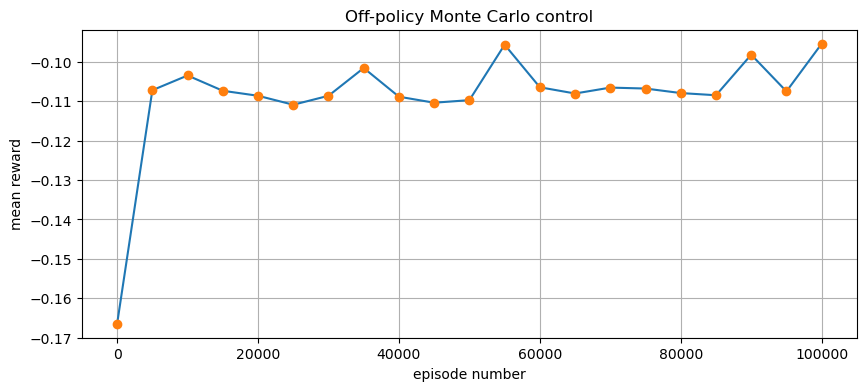

In [16]:
mean_reward_plot(
    x=np.arange(0, total_episodes, check_pi_step),
    y=mean_reward_by_current_policy, 
    title="Off-policy Monte Carlo control"
)

**Полученная матрица Q**

In [17]:
print(Q)

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.23504274 -0.9       ]
 [-0.2119712  -0.81      ]
 [-0.2145383  -0.81      ]
 [-0.22714456 -0.9       ]
 [-0.14276228 -0.13723403]
 [-0.23337666 -0.9       ]
 [-0.00425532  0.08798629]
 [-0.004095    0.12903665]
 [-0.22152987 -0.20636087]
 [-0.22114754 -0.2220875 ]
 [-0.21837564 -0.2203367 ]
 [-0.22920564 -0.22963966]
 [-0.22363136 -0.22478843]
 [-0.14894209 -0.15096255]
 [ 0.00739919 -0.00374532]
 [ 0.13932961 -0.00398645]
 [ 0.29805926 -0.00174613]
 [ 0.5974302   0.        ]
 [ 0.          0.        ]]


**Выводы:**
* Здесь результат получился похуже, чем для **on-policy MC control**. Но лучше, чем для первоначальной стратегии. Средний проигрыш  $0.11$. *Лучший результат: проигрыш $0.09$.*
* Матрица **Q**: здесь результаты чуть отличаются. Видно, что она 'поощряет' сильнее добрать на руку карту, если сумма на руках меньше $11$. И если на руках больше $11$, то результаты совпадают: $18,\ 19,\ 20,\ 21$ - перестаем добирать, меньше 18 - одинаково невыгодно ни одно из действий.

# Q-learning

In [647]:
def Q_learning_episode(env, Q, alpha, eps, gamma):
    """Q-learning для одного эпизода."""
    
    state = env.reset()[0]
    terminated = False

    while not terminated:

        pi = compute_policy_by_Q(Q)

        sum_hand = state[0]
        if np.random.rand() > eps:
            action = pi[sum_hand]
        else:
            action = np.random.randint(nA)

        state, reward, terminated, _, _ = env.step(action)

        new_state = state[0]
        if new_state > 21:
            new_state = 22

        Q[sum_hand][action] = Q[sum_hand][action] \
                + alpha * (reward + gamma * max(Q[new_state]) - Q[sum_hand][action])

    return Q

In [648]:
Q = np.zeros((nS, nA))

total_episodes = 100_001
alpha = 0.0001
epsilon = 0.8
gamma = 0.5
check_pi_step = 5000  # как часто проверяем стратегию

mean_reward_by_current_policy = []

for n_episode in tqdm(range(total_episodes)):
     
    if n_episode % check_pi_step == 0:
        pi = compute_policy_by_Q(Q)
        mean_reward = get_mean_reward(env, pi, n_episodes=200_000)
        mean_reward_by_current_policy.append(mean_reward)
    
    Q = Q_learning_episode(env, Q, alpha, epsilon, gamma)  

100%|██████████████████████████████████| 100001/100001 [11:41<00:00, 142.46it/s]


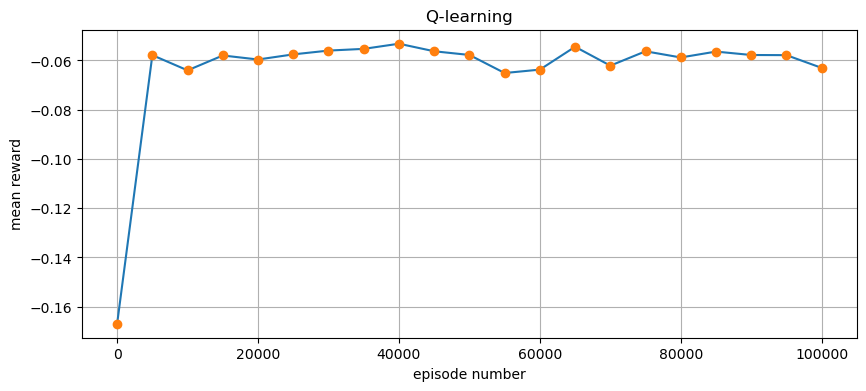

In [649]:
mean_reward_plot(
    x=np.arange(0, total_episodes, check_pi_step),
    y=mean_reward_by_current_policy, 
    title="Q-learning"
)

**Полученная матрица Q**

In [654]:
print(Q.round(2))

[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [-0.01 -0.  ]
 [-0.02 -0.  ]
 [-0.03 -0.  ]
 [-0.04 -0.  ]
 [-0.05 -0.  ]
 [-0.06 -0.  ]
 [-0.07  0.01]
 [-0.08  0.01]
 [-0.17 -0.14]
 [-0.19 -0.17]
 [-0.2  -0.2 ]
 [-0.22 -0.22]
 [-0.23 -0.23]
 [-0.16 -0.22]
 [-0.   -0.23]
 [ 0.15 -0.25]
 [ 0.43 -0.37]
 [ 0.61 -0.16]
 [ 0.    0.  ]]


**Выводы:**

* Средний проигрыш получился порядка $0.06$ , что лучше, чем первоначальная простая стратегия. И примерно совпадает с результатами **on-policy MC control**. Но здесь результат как будто более стабильный по ходу обучения.
* По матрице **Q** примерно такие же выводы, как и ранее.

# Вывод по первой части

> Выиграть у казино не получилось. 
> 
> Средний проигрыш удалось уменьшить с $0.18$ до $0.06\ ..\ 0.1$ в зависимости от метода.

# Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
* Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
* Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


> Реализуем в этой части только **Q-learning**. Но 2 варианта: обычный и **double Q-learning**.

In [203]:
# количество действий
nA = 3

In [606]:
def run_episode(env, pi, eps=0.0):
    """Играем один эпизод."""
     
    state = env.reset()[0]
    terminated = False
    double_game = False
    
    states, actions, rewards = [], [], []
    
    while not terminated:
        
        sum_hand = state[0]
        
        if double_game:
            action = 0  
        else:
            if np.random.rand() > eps:
                action = pi[sum_hand]
            else:
                action = np.random.randint(nA)
            if action == 2:
                double_game = True
        
        state, reward, terminated, _, _ = env.step(min(action, 1))
        
        if double_game:
            reward *= 2
        
        states.append(sum_hand)
        actions.append(action)
        rewards.append(reward)
        
    return states, actions, rewards

# Q-learning

In [644]:
def Q_learning_episode_with_double(env, Q, alpha, eps, gamma):
    """Q-learning для одного эпизода с учетом удвоения ставок."""
    
    state = env.reset()[0]
    terminated = False
    double_game = False

    while not terminated:

        pi = compute_policy_by_Q(Q)  # текущая стратегия

        sum_hand = state[0]
        
        if double_game:
            action = 0  
        else:
            if np.random.rand() > eps:
                action = pi[sum_hand]
            else:
                action = np.random.randint(nA)
            if action == 2:
                double_game = True

        state, reward, terminated, _, _ = env.step(min(action, 1))
        
        if double_game:
            reward *= 2

        new_state = state[0]
        if new_state > 21:
            new_state = 22

        Q[sum_hand][action] = Q[sum_hand][action] \
                + alpha * (reward + gamma * max(Q[new_state]) - Q[sum_hand][action])

    return Q

In [645]:
Q = np.zeros((nS, nA))

total_episodes = 100_001
alpha = 0.0001
epsilon = 0.8
gamma = 0.5
check_pi_step = 5000  # как часто проверяем стратегию

mean_reward_by_current_policy = []

for n_episode in tqdm(range(total_episodes)):
    
    if n_episode % check_pi_step == 0:
        pi = compute_policy_by_Q(Q)
        mean_reward = get_mean_reward(env, pi, n_episodes=200_000)
        mean_reward_by_current_policy.append(mean_reward)
    
    Q = Q_learning_episode_with_double(env, Q, alpha, epsilon, gamma) 

100%|██████████████████████████████████| 100001/100001 [12:16<00:00, 135.70it/s]


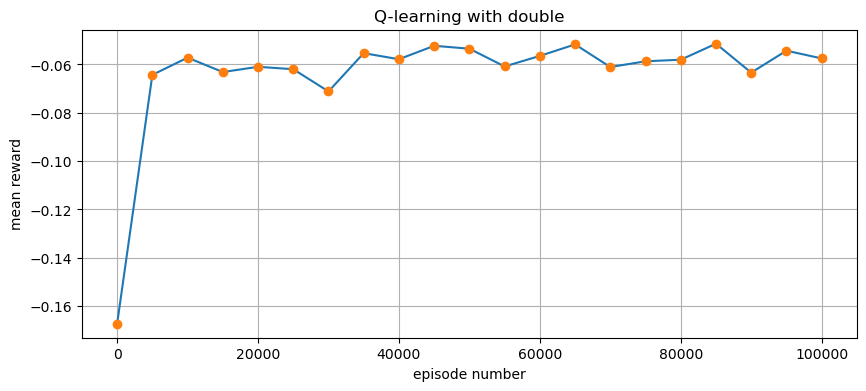

In [646]:
mean_reward_plot(
    x=np.arange(0, total_episodes, check_pi_step),
    y=mean_reward_by_current_policy, 
    title="Q-learning with double"
)

**Выводы:**

> Результат получился такой же, как и без удвоения: средний проигрыш около $0.06$. Значит удваивать не стоит просто так:)

# Double Q-learning

In [640]:
def double_Q_learning_episode_with_double(env, Q1, Q2, alpha, eps, gamma):
    """double Q-learning для одного эпизода с учетом удвоения ставок."""
    
    state = env.reset()[0]
    terminated = False
    double_game = False

    while not terminated:

        pi = compute_policy_by_Q(Q1)  # текущая стратегия

        sum_hand = state[0]
        
        if double_game:
            action = 0  
        else:
            if np.random.rand() > eps:
                action = pi[sum_hand]
            else:
                action = np.random.randint(nA)
            if action == 2:
                double_game = True

        state, reward, terminated, _, _ = env.step(min(action, 1))
        
        if double_game:
            reward *= 2

        new_state = state[0]
        if new_state > 21:
            new_state = 22
        
        if np.random.random() < 0.5:
            Q1[sum_hand][action] = Q1[sum_hand][action] \
                    + alpha * (reward + gamma * max(Q2[new_state]) - Q1[sum_hand][action])
        else:
            Q2[sum_hand][action] = Q2[sum_hand][action] \
                    + alpha * (reward + gamma * max(Q1[new_state]) - Q2[sum_hand][action])

    return Q1, Q2

In [641]:
Q1 = np.zeros((nS, nA))
Q2 = np.zeros((nS, nA))

total_episodes = 100_001
alpha = 0.0001
epsilon = 0.8
gamma = 0.5
check_pi_step = 5000  # как часто проверяем стратегию

mean_reward_by_current_policy = []

for n_episode in tqdm(range(total_episodes)):
    
    if n_episode % check_pi_step == 0:
        pi = compute_policy_by_Q(Q1)
        mean_reward = get_mean_reward(env, pi, n_episodes=200_000)
        mean_reward_by_current_policy.append(mean_reward)
    
    Q1, Q2 = double_Q_learning_episode_with_double(env, Q1, Q2, alpha, epsilon, gamma) 

100%|██████████████████████████████████| 100001/100001 [11:54<00:00, 139.99it/s]


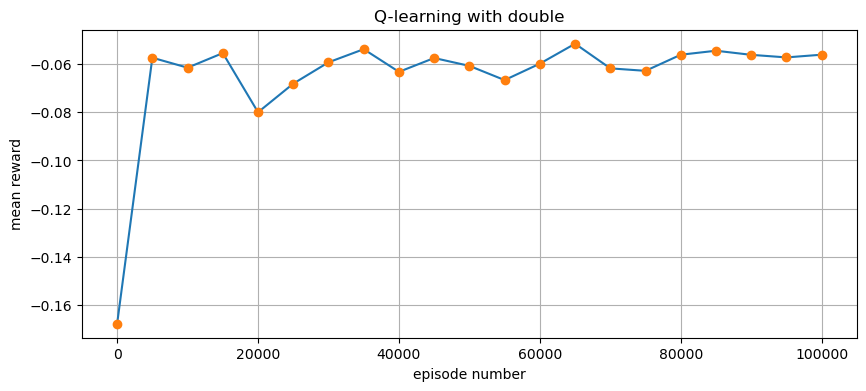

In [642]:
mean_reward_plot(
    x=np.arange(0, total_episodes, check_pi_step),
    y=mean_reward_by_current_policy, 
    title="Q-learning with double"
)

**Выводы:**

> Не отличается от простого метода **Q-learning**.

# Вывод по второй части

* Результат не отличается от случая, когда мы играли без удвоения. Т.е. играть с удвоением не выгодно, когда колоду постоянно перемешивают. Перебор гиперпараметров ситуацию тоже не улучшил.
* Простой **Q-learning** и **double Q-learning** показали одинаковые результаты.

# Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.


Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.
* Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
* Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


> Будем использовать метод **"Половинки"**. Вот отсюда взял правила подсчета: https://casino.ru/podschet-kart-v-blekdzheke/
>
> А также решать задачу методом **double Q-learning**.

In [655]:
from typing import Optional

from gym import spaces
from gym.utils import seeding
from gym.error import DependencyNotInstalled
from gym.envs.toy_text.blackjack import BlackjackEnv


class Blackjack_V2(BlackjackEnv):
    """Блэкджек, где одна колода, и карты перемешиваем только после того, как их осталось меньше или равно 15."""
    
    def __init__(self, natural=True, sab=False):
        super().__init__(natural=natural, sab=sab)
        self.seed()
        self.initial_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.deck = self.initial_deck.copy()
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)
        return card
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        
        shuffle_card = False
        if len(self.deck) <= 15:
            shuffle_card = True
            self.deck = self.initial_deck.copy()
            
        self.dealer = self.draw_hand(np.random)
        self.player = self.draw_hand(np.random)

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        return self._get_obs(), shuffle_card

In [656]:
def get_mean_reward(env, pi, n_episodes):
    """Расчет среднего выигрыша."""
    
    mean_reward = 0  # средний выигрыш
    cost = 0
    
    for i in range(n_episodes):
        _, _, rewards, cost = run_episode(env, pi, cost)
        mean_reward = (mean_reward * i + rewards[-1]) / (i + 1)
        
    return mean_reward

In [657]:
def run_episode(env, pi, cost, eps=0.0):
    """Играем один эпизод."""
     
    state, shuffle_card = env.reset()
    
    if shuffle_card:
        cost = 0
        
    for card in env.player:
        cost += card_cost[card]
    cost += card_cost[env.dealer[0]]
          
    terminated = False
    double_game = False
    
    states, actions, rewards = [], [], []
    
    while not terminated:
        
        sum_hand = state[0]
        
        if double_game:
            action = 0  
        else:
            if np.random.rand() > eps:
                action = pi[s2i[(sum_hand, cost)]]
            else:
                action = np.random.randint(nA)
            if action == 2:
                double_game = True
        
        state, reward, terminated, _, _ = env.step(min(action, 1))
        
        if action != 0:
            cost += card_cost[env.player[-1]]
        
        if double_game:
            reward *= 2
        
        states.append(sum_hand)
        actions.append(action)
        rewards.append(reward)
        
    for card in env.dealer[1:]:
        cost += card_cost[card]
        
    return states, actions, rewards, cost

In [545]:
def double_Q_learning_episode_with_double_Hoffman(env, Q1, Q2, alpha, eps, gamma, cost):
    """double Q-learning для одного эпизода с учетом удвоения ставок."""
    
    state, shuffle_card = env.reset()

    if shuffle_card:
        cost = 0
        
    # смотрим на карты игрока
    for card in env.player:
        cost += card_cost[card]
    # первая карта дилера
    cost += card_cost[env.dealer[0]]
        
    terminated = False
    double_game = False

    while not terminated:

        pi = compute_policy_by_Q(Q1)  # текущая стратегия

        sum_hand = state[0]
        
        if double_game:
            action = 0  
        else:
            if np.random.rand() > eps:
                action = pi[s2i[(sum_hand, cost)]]
            else:
                action = np.random.randint(nA)
            if action == 2:
                double_game = True

        state, reward, terminated, _, _ = env.step(min(action, 1))
        
        k = (sum_hand, cost)
        
        # учтем новую карту игрока
        if action != 0:
            cost += card_cost[env.player[-1]]
        
        if double_game:
            reward *= 2

        new_state = state[0]
        if new_state > 21:
            new_state = 22
            
        if np.random.random() < 0.5:
            Q1[s2i[k]][action] = Q1[s2i[k]][action] \
                    + alpha * (reward + gamma * max(Q2[s2i[(new_state, cost)]]) - Q1[s2i[k]][action])
        else:
            Q2[s2i[k]][action] = Q2[s2i[k]][action] \
                    + alpha * (reward + gamma * max(Q1[s2i[(new_state, cost)]]) - Q2[s2i[k]][action])
        
    # учтем оставшиеся карты дилера
    for card in env.dealer[1:]:
        cost += card_cost[card]

    return Q1, Q2, cost

In [677]:
env = Blackjack_V2(natural=False, sab=False)

In [678]:
# Метод Половинки
card_cost = {
    1: -1,
    2: 0.5,
    3: 0.5,
    4: 1,
    5: 1.5,
    6: 1,
    7: 0.5,
    8: 0,
    9: -0.5,
    10: -1,
}

min_cost_value = -22
max_cost_value = 20

In [679]:
possible_states = list(itertools.product(np.arange(23), np.arange(min_cost_value, max_cost_value + 0.5, 0.5)))

# словарь перевода состояний в порядковый номер
s2i = {s: i for i, s in enumerate(possible_states)}

nS = len(possible_states)
nS

1955

In [746]:
Q1 = np.zeros((nS, nA))
Q2 = np.zeros((nS, nA))

total_episodes = 200_001
alpha = 0.001
eps = 0.9
gamma = 1
check_pi_step = 2_000  # как часто проверяем стратегию

cost = 0  # учет карт (благоприятность ситуации для игрока)

policy_list = []  # список полученных стратегий

for n_episode in tqdm(range(total_episodes)):
    
    if n_episode % check_pi_step == 0:
        policy_list.append(compute_policy_by_Q(Q1))
    
    Q1, Q2, cost = double_Q_learning_episode_with_double_Hoffman(env, Q1, Q2, alpha, eps, gamma, cost) 

100%|█████████████████████████████████| 200001/200001 [00:39<00:00, 5059.07it/s]


In [754]:
mean_reward_by_current_policy = []

for pi in tqdm(policy_list):
    env = Blackjack_V2(natural=True, sab=False)
    mean_reward = get_mean_reward(env, pi, n_episodes=200_000)
    mean_reward_by_current_policy.append(mean_reward)

100%|███████████████████████████████████████████| 90/90 [48:31<00:00, 32.35s/it]


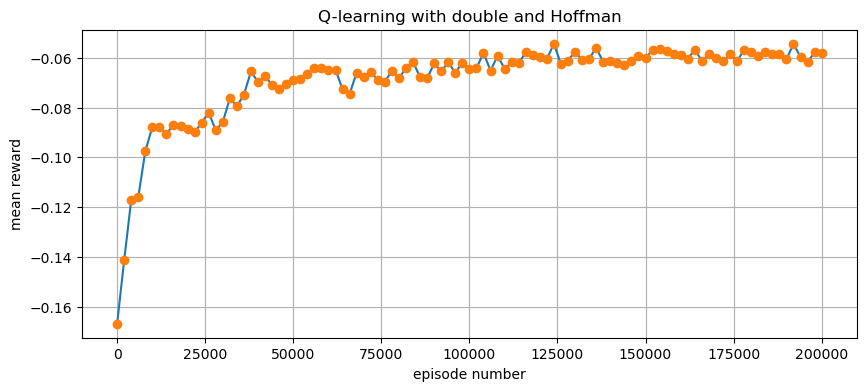

In [755]:
mean_reward_plot(
    x=np.arange(0, total_episodes, check_pi_step),
    y=mean_reward_by_current_policy, 
    title="Q-learning with double and Hoffman"
)

# Выводы по третьей части
* Средний проигрыш составил порядка $0.06$.
* Если сравнить с результатами из *пп.1 и 2*, то средний проигрыш остался таким же. При этом путь к оптимальной стратегии более медленный. Если до этого нам хватало 5.000 - 10.000 тысяч итераций, то сейчас порядка 100.000, чтобы достичь тех же результатов. Но это еще можно объяснить тем, что количество состояний у нас возросло на 2 порядка.

# Глобальный вывод

* Все методы обучения показывают уменьшение среднего проигрыша по сравнению с первоначальной простой стратегией.
* Везде проигрыш составил порядка $0.06$. Обыграть казино не получилось.
* В 3 части сходимость алгоритма более медленная. Вероятно, из-за того, что количество состояний здесь на 2 порядка больше.
* Также я рассматривал поначалу в качестве состояний сумму карт на руках. Возможно, правильнее было бы рассматривать в качестве состояний комбинацию из сумм карт на руках игрока и дилера.
* ДЗ очень интересное. На практике пощупать все эти методы. Много чего не успел сделать, что хотелось попробовать. Но спасибо:)